In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from sklearn.decomposition import PCA

from scipy.io import loadmat
from scipy.signal import welch
from scipy.optimize import curve_fit

from lsc import LangevinSparseCoding
from utils import KLDivergence

# https://github.com/rctn/sparsecoding
from sparsecoding.visualization import plot_dictionary 
from sparsecoding.data.transforms.patch import sample_random_patches


## What do dyanmics look like in latent space for natural images
* Load trained dictionary
    * or generate a gabor dictionary with different orientiations
* do sampling on natural images
* compute PCs in latent space to visualize in low dims 
    * or look at correlation matrix to look at independent/correlated dyanmics 
* are there any common features between dictionary elements & their corresponding dynamics  

(<Figure size 500x500 with 1 Axes>, <Axes: >)

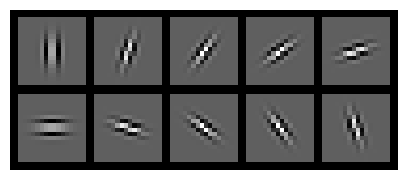

In [2]:
def generate_gabor(size, omega, theta, func=np.cos, K=np.pi):
    [x, y] = np.meshgrid(np.linspace(-1,1,size[0]),np.linspace(-1,1,size[1]))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
    gabor = gauss * sinusoid
    return gabor

n_latent = 10
omega = 20
patch_size = 16

A = np.empty([patch_size**2,n_latent])
for i in range(n_latent):
    g = generate_gabor(
        size=(patch_size,patch_size),
        omega=omega,    # changes size
        theta=(i/n_latent)*np.pi,   # changes orientation
    )
    A[:,i] = g.flatten()/np.linalg.norm(g.flatten())

plot_dictionary(torch.tensor(A),nrow=5,scale_each=False,size=5)

torch.Size([10, 1, 512, 512])


(<Figure size 500x500 with 1 Axes>, <Axes: >)

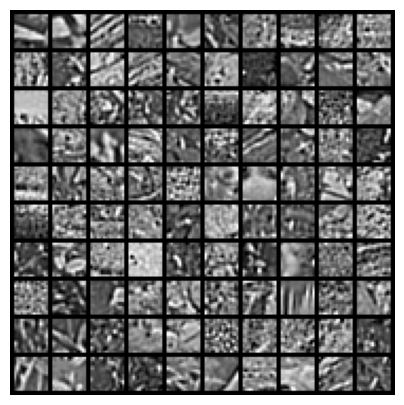

In [3]:
# download @ http://www.rctn.org/bruno/sparsenet/
img_dir = '/Users/belsten/Documents/datasets/IMAGES.mat'

images = loadmat(img_dir)['IMAGES']
images = torch.tensor(images).permute([2,0,1]).unsqueeze(1)
images = images.type(torch.float32)
print(images.shape)

n_images = images.shape[-1]
n_patches = int(1e3)
patch_size = 16
patches = sample_random_patches(image=images, patch_size=patch_size,num_patches=n_patches)
data = patches.reshape([n_patches, -1])
plot_dictionary(data[0:100,:].T,nrow=10,size=5)

In [71]:
n_features = patch_size**2
sparsity_penalty = 1.
temperature = 1
dt = 1e-3
mass = 0.075
NOISE_MEAN, NOISE_STD = 0 , 0.1

C = lambda s: s.abs().sum(dim=1)
Cprime = lambda s: torch.sign(s)

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
    gauss_std=NOISE_STD
)

lsc.A = torch.FloatTensor(A)

In [72]:
tmax = int(1e5)
image_patch_idx = 1

s_inference = torch.zeros([n_patches,n_latent]) #Change to L0
s_map = torch.zeros([n_patches,n_latent]) #Change to L0
v = torch.zeros_like(s_inference) #Change to L0

S = torch.empty([n_patches,tmax+1,n_latent])
Smap = torch.empty([n_patches,tmax+1,n_latent])
S[:,0,:] = torch.clone(s_inference)
for n in tqdm(range(tmax)):
    s_map -= torch.clone(lsc.dt*lsc.energy_grad(data,s_map))
    
    ds,dv = lsc.second_order_langevin_update(data,s_inference,v)
    s_inference += torch.clone(ds)
    v += torch.clone(dv)
    S[:,n+1,:] = torch.clone(s_inference)
    Smap[:,n+1,:] = torch.clone(s_map)
# Sbar = S.mean(axis=0)

100%|██████████| 100000/100000 [01:35<00:00, 1049.34it/s]


In [73]:
Sbar = S.mean(axis=1)

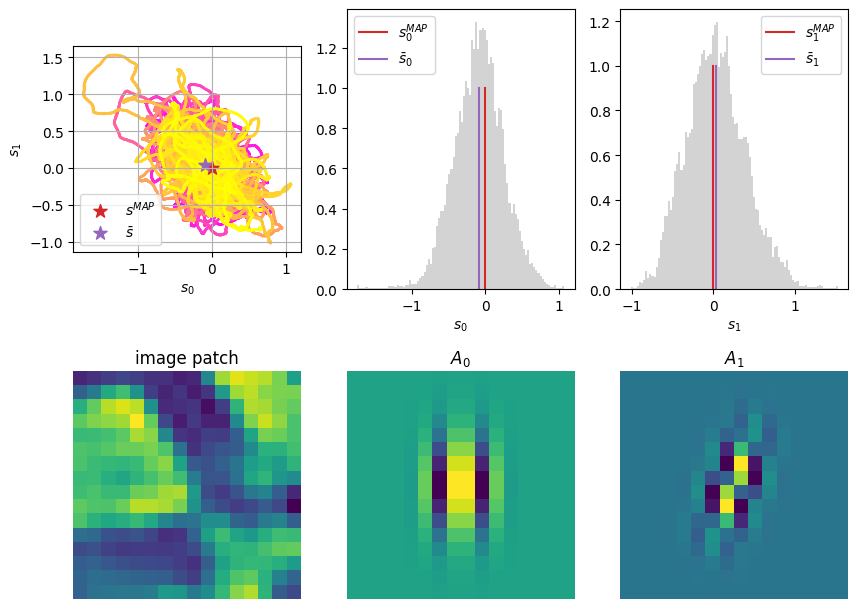

In [74]:
s_id1,s_id2 = 0,1

fig, axes = plt.subplots(2,3, figsize=(10, 8))
axes = axes.flatten()
colors = cm.spring(np.linspace(0, 1, S.shape[1]))
axes[0].scatter(*S[image_patch_idx,:,(s_id1,s_id2)].T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'$s_%d$'%(s_id1))
axes[0].set_ylabel(r'$s_%d$'%(s_id2))
axes[0].grid()
axes[0].scatter(Smap[image_patch_idx,-1,s_id1],Smap[image_patch_idx,-1,s_id2],marker='*',s=100,label=r'$s^{MAP}$',c='C3')
axes[0].scatter(Sbar[image_patch_idx,s_id1],   Sbar[image_patch_idx,s_id2],marker='*',s=100,label=r'$\bar{s}$',c='C4')
# np.expand_dims(Smap[-1,(s_id1,s_id1)],0).T
axes[0].legend()

axes[1].hist(S[image_patch_idx,:, s_id1], fc='lightgrey', bins=100, density=True)
# axes[1].plot(s_, p_, 'r--')
axes[1].set_xlabel(r'$s_%d$'%(s_id1))
axes[1].plot([Smap[image_patch_idx,-1,s_id1],Smap[image_patch_idx,-1,s_id1]],[0,1],color='C3',label=r'$s^{MAP}_%d$'%(s_id1))
axes[1].plot([Sbar[image_patch_idx,s_id1],Sbar[image_patch_idx,s_id1]],[0,1],color='C4',label=r'$\bar{s}_%d$'%(s_id1))
axes[1].legend()

axes[2].hist(S[image_patch_idx,:, s_id2], fc='lightgrey', bins=100, density=True)
# axes[2].plot(s_, p_, 'g--')
axes[2].set_xlabel(r'$s_%d$'%(s_id2))
# plt.suptitle(rf'$dt = {dt:.2f} M^{{-1}}$ ; $T = {TAU_SCALE} \mu^{{-1}}$')
# plt.savefig(f'{TAU_SCALE}_{DT_SCALE}.pdf')
axes[2].plot([Smap[image_patch_idx,-1,s_id2],Smap[image_patch_idx,-1,s_id2]],[0,1],color='C3',label=r'$s^{MAP}_%d$'%(s_id2))
axes[2].plot([Sbar[image_patch_idx,s_id2],Sbar[image_patch_idx,s_id2]],[0,1],color='C4',label=r'$\bar{s}_%d$'%(s_id2))
axes[2].legend()

# plot the energy function on a smaller scale 
ax = axes[3]
ax.imshow(data[image_patch_idx,:].reshape([patch_size,patch_size]))
ax.set_aspect('equal')
ax.set_title(r'image patch')
ax.set_axis_off()

ax = axes[4]
ax.imshow(A[:,s_id1].reshape([patch_size,patch_size]))
ax.set_aspect('equal')
ax.set_title(r'$A_%d$'%(s_id1))
ax.set_axis_off()

ax = axes[5]
ax.imshow(A[:,s_id2].reshape([patch_size,patch_size]))
ax.set_aspect('equal')
ax.set_title(r'$A_%d$'%(s_id2))
ax.set_axis_off()


### Project onto PCs

In [75]:
pca = PCA(n_components=n_latent)
S_pcs = pca.fit_transform(S[image_patch_idx,:,:])
Sbar_pcs = np.mean(S_pcs,axis=0)

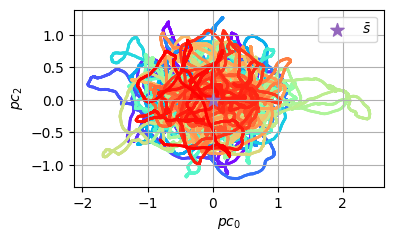

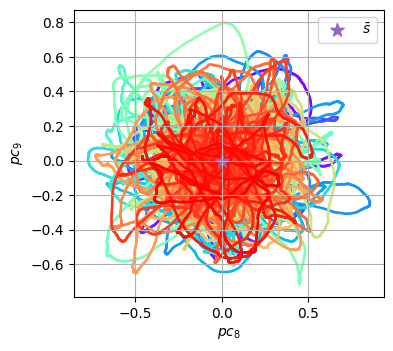

In [82]:
pc_v1,pc_v2 = 0,2

fig, ax = plt.subplots(1,1, figsize=(4, 4))
colors = cm.rainbow(np.linspace(0, 1, S.shape[1]))
ax.scatter(*S_pcs[:,(pc_v1,pc_v2)].T, color=colors, s=1)
ax.set_aspect('equal')
ax.set_xlabel(r'$pc_%d$'%(pc_v1))
ax.set_ylabel(r'$pc_%d$'%(pc_v2))
ax.scatter(Sbar_pcs[pc_v1],   Sbar_pcs[pc_v2],marker='*',s=100,label=r'$\bar{s}$',c='C4')
ax.legend()
ax.grid()

pc_v1,pc_v2 = 8,9

fig, ax = plt.subplots(1,1, figsize=(4, 4))
colors = cm.rainbow(np.linspace(0, 1, S.shape[1]))
ax.scatter(*S_pcs[:,(pc_v1,pc_v2)].T, color=colors, s=1)
ax.scatter(Sbar_pcs[pc_v1],   Sbar_pcs[pc_v2],marker='*',s=100,label=r'$\bar{s}$',c='C4')
ax.set_aspect('equal')
ax.set_xlabel(r'$pc_%d$'%(pc_v1))
ax.set_ylabel(r'$pc_%d$'%(pc_v2))
ax.legend()
ax.grid()

## Compute correlation matrix

### Correlation matrix for a single image

Text(0.5, 1.0, 'Inner product\nof dictionary')

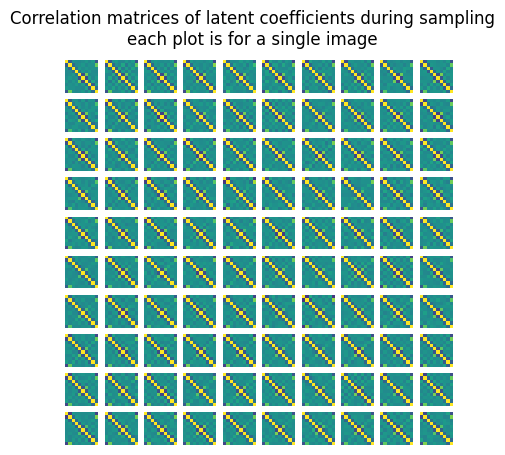

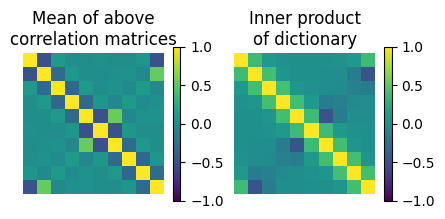

In [69]:
n_row,n_col = 10,10
fig,axs = plt.subplots(n_row,n_col,figsize=(5,5))
fig.suptitle('Correlation matrices of latent coefficients during sampling\neach plot is for a single image')
axs = axs.flatten()
cmats = np.empty([n_row*n_col,n_latent,n_latent])
for i in range(n_row*n_col):
    ax = axs[i]
    corr_mat = np.corrcoef(S[i,:,:].T)
    cmats[i,:,:] = corr_mat
    cp = ax.imshow(corr_mat,vmin=-1,vmax=1)
    # plt.colorbar(cp)
    ax.set_aspect('equal')
    ax.set_axis_off()


fig,axs = plt.subplots(1,2,figsize=(5,2))
ax = axs[0]
cp = ax.imshow(np.mean(cmats,axis=0),vmin=-1,vmax=1)
plt.colorbar(cp)
ax.set_aspect('equal')
ax.set_axis_off()
ax.set_title('Mean of above\ncorrelation matrices')

ax = axs[1]
cp = ax.imshow(A.T@A,vmin=-1,vmax=1)
plt.colorbar(cp)
ax.set_aspect('equal')
ax.set_axis_off()
ax.set_title('Inner product\nof dictionary')

Notes:
* positive inner product between dictionary elements seems to result in negative correlation during sampling
    * this makes sense to me since we have "explaining away" 
* How could this inform a richer prior on the coefficients?


In [20]:
Sbar_pcs

array([ 2.84214252e-17, -3.75162813e-17, -2.89898537e-17,  3.06951392e-17,
        9.94749883e-18, -1.53475696e-17, -2.44424257e-17, -7.81589193e-18,
       -5.96849930e-18, -5.11585654e-18])

## Compute autocorrelation

In [78]:
def xcorr(x):
    l = 2 ** int(np.log2(x.shape[1] * 2 - 1))
    fftx = np.fft.fft(x, n = l, axis = 1)
    ret = np.fft.ifft(fftx * np.conjugate(fftx), axis = 1)
    # ret = np.fft.fftshift(ret, axes=1)
    return ret
Sacorr = xcorr(S[image_patch_idx,:,:].T)

In [79]:
Sacorr.shape

(10, 131072)

/Users/belsten/Documents/github/LangevinSparseCoding/.venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


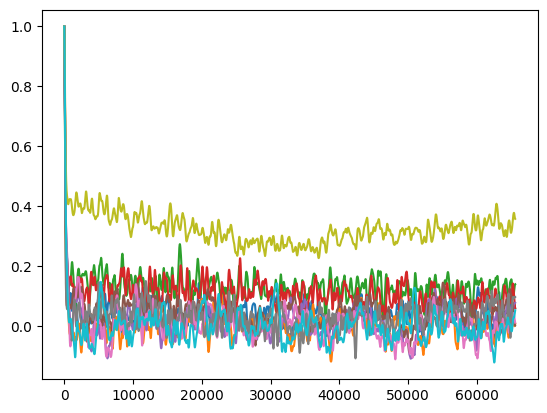

In [80]:
fig,ax = plt.subplots()
ax.plot((Sacorr/np.max(Sacorr,axis=1,keepdims=True))[:,:int(Sacorr.shape[1]//2)].T)

Text(0, 0.5, 'Power')

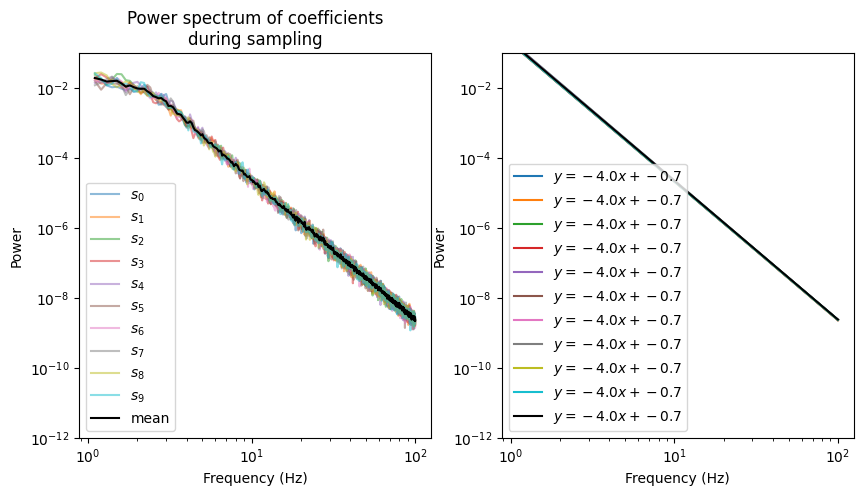

In [77]:
image_patch_idx = 1

linear = lambda x,m,b : m*x+b

fs = 1/lsc.dt.item()
freqs = np.fft.fftfreq(S.shape[1], 1/fs)
ps = np.abs(np.fft.fft(S[image_patch_idx,:,:],axis=0))**2
idx = np.squeeze(np.argwhere(np.logical_and(freqs<100,freqs>1)))

freqs,ps = welch(S[image_patch_idx,:,:],return_onesided=False,fs=fs,axis=0,nperseg=10000)
idx = np.squeeze(np.argwhere(np.logical_and(freqs<100,freqs>1)))

ymin,ymax = 1e-12,1e-1

# ymin,ymax = 1e-7,1e7
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
ax.loglog(freqs[idx], ps[idx,:],alpha=0.5)
ax.loglog(freqs[idx], np.mean(ps[idx,:],axis=1),alpha=1,color='black')
ax.set_title('Power spectrum of coefficients\nduring sampling')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
labels = [r'$s_%d$'%(i) for i in range(S.shape[2])]
labels.append('mean')
ax.legend(labels)
ax.set_ylim([ymin,ymax])
# ax.set_xticks([10,50,100,200])

ax = axs[1]
for i in range(n_latent):
    # fit 1/f function
    popt, pcov = curve_fit(linear, np.log10(freqs[idx]), np.log10(ps[idx,i]))
    ax.loglog(
        freqs[idx], 
        10**linear(np.log10(freqs[idx]),popt[0],popt[1]),
        label=r'$y=%.1fx+%.1f$'%(popt[0],popt[1])
    )

popt, pcov = curve_fit(linear, np.log10(freqs[idx]), np.log10(np.mean(ps[idx,:],axis=1)))
ax.loglog(
    freqs[idx], 
    10**linear(np.log10(freqs[idx]),popt[0],popt[1]),
    color='black',
    label=r'$y=%.1fx+%.1f$'%(popt[0],popt[1])
)

ax.set_ylim([ymin,ymax])
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')